In [3]:
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_path = '_static/playback-thumbnail.png'

import librosa
# We'll need IPython.display's Audio widget
from IPython.display import Audio

# We'll also use `mir_eval` to synthesize a signal for us
import mir_eval.sonify

import csv
import os
import json
from pydub import AudioSegment

e:\MDNE\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Projeto de Reconhecimento de Acordes de Violão

## Pedro Vinicius Alves Silva - 10727865

## 1) Identificação do Problema

Identificar um acorde apenas pelo som produzido é uma habilidade desenvolvida por músicos durante sua prática. Ela é essencial para acompanhar e improvisar com outros músicos. No contexto computacional, a identificação de acordes pode auxiliar o desenvolvimento de algoritmos de processamento, análise de estrutura e sistema de recomendação de músicas.
Esse projetivo objetiva então a criação de um sistema de identicação dos 12 acordes maiores tocados em um violão, sendo eles: A, A#, B, C, C#, D, D#, E,E#,F,F#,G,G#. O produto final trata-se de um dashboard no qual o usuário pode submeter uma gravação própria de um acorde para identificação.

### Conjunto de Dados

Para a realização desse projeto usamos o conjunto de dados 'GuitarSet' que possui a gravação em alta qualidade de diversos acordes tocados em um violão. O conjunto original possui 360 gravações de músicos tocando, abaixo apresentamos um exemplo:

In [2]:
y, sr = librosa.load('00_BN1-129-Eb_comp_hex.wav')
Audio(data = y,rate = sr)

In [3]:
y, sr = librosa.load('00_BN1-129-Eb_solo_hex.wav')
Audio(data = y,rate = sr)

## 2) Pré-Processamento

Em uma única gravação, o músico pode tocar vários acordes. Para separarmos cada um deles, usamos o conjunto de metadados também disponibilizados com o conjunto de dados.

In [4]:
def read_metadata(metadata_name):
    # Opening JSON file
    f = open(metadata_name)
    
    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    chord = data['annotations'][14]['data']
    #key_mode = data['annotations'][16]['data']

    return chord


chord = read_metadata('presentation/00_BN1-129-Eb_comp.jams')
print(chord)


[{'time': 0.0, 'duration': 7.441860465116279, 'value': 'D#:maj', 'confidence': None}, {'time': 7.441860465116279, 'duration': 3.72093023255814, 'value': 'G#:maj', 'confidence': None}, {'time': 11.162790697674419, 'duration': 3.720930232558139, 'value': 'D#:maj', 'confidence': None}, {'time': 14.883720930232558, 'duration': 1.8604651162790713, 'value': 'A#:maj', 'confidence': None}, {'time': 16.74418604651163, 'duration': 1.8604651162790695, 'value': 'G#:maj', 'confidence': None}, {'time': 18.6046511627907, 'duration': 3.71974883720927, 'value': 'D#:maj', 'confidence': None}]


Uma das chaves do arquivo de metadado é o tempo durante o acorde foi tocado e seu nome, como apresentado acima. Com essa informação, o seguinte algoritmo de pré-processamento foi usado:

1. Descomprimimos o áudio e o metadado referente em um pasta auxiliar ('aux_folder/')
2. Recortamos todos os acordes presentes em um áudio e o salvamos em 'processed_audio/'
3. Salvamos o nome do acorde recortado, o nome do arquivo original e a nomenclatura do acorde em uma tabela ('metadata.csv')
4. Deletamos os arquivos da pasta auxiliar

Fazendo isso para todos os arquivos, **obtivemos 2160 acordes.**

Obs: utilizamos apenas os arquivos definidos como comp, nos quais os músicos tocam os acordes. Arquivos definidos como 'solo' são gravações dos músicos solando em cima da gravação 'comp'.

**Os scripts para o pré-processamento estão disponíveis e documentados integralmente em 'preprocess.ipynb'.**

Um exemplo do áudio pré-processado é apresentado abaixo:

In [5]:
y, sr = librosa.load('presentation/file_1097.wav')
Audio(data = y,rate = sr)

Como apresentaremos a seguir, esse áudio refere-se ao acorde A#min

## 3) Extração de Padrões

## Análise Exploratória

Com nosso arquivo 'metadata.csv' gerado na etapa anterior, podemos analisar o conjunto de dados obtido.

In [5]:
import pandas as pd
df = pd.read_csv('metadata_v3.csv', sep = ';')
df.head()

,Filename,Loc,Acorde,Arquivo Original
0,file_1177.wav,processed_audio/,A#:min,01_SS2-88-F_comp_hex.wav
1,file_1178.wav,processed_audio/,D#:7,01_SS2-88-F_comp_hex.wav
2,file_1179.wav,processed_audio/,G#:maj,01_SS2-88-F_comp_hex.wav
3,file_1180.wav,processed_audio/,C#:maj,01_SS2-88-F_comp_hex.wav
4,file_1181.wav,processed_audio/,G:hdim7,01_SS2-88-F_comp_hex.wav


In [6]:
nchords = len(df['Acorde'].unique())
print('Temos um total de', nchords, 'acordes únicos')

Temos um total de 42 acordes únicos


In [7]:
naudios = len(df)
print('Temos um total de', naudios, 'aúdios únicos')

Temos um total de 2160 aúdios únicos


Vamos analisar a distribuição desses acordes no conjunto de dados

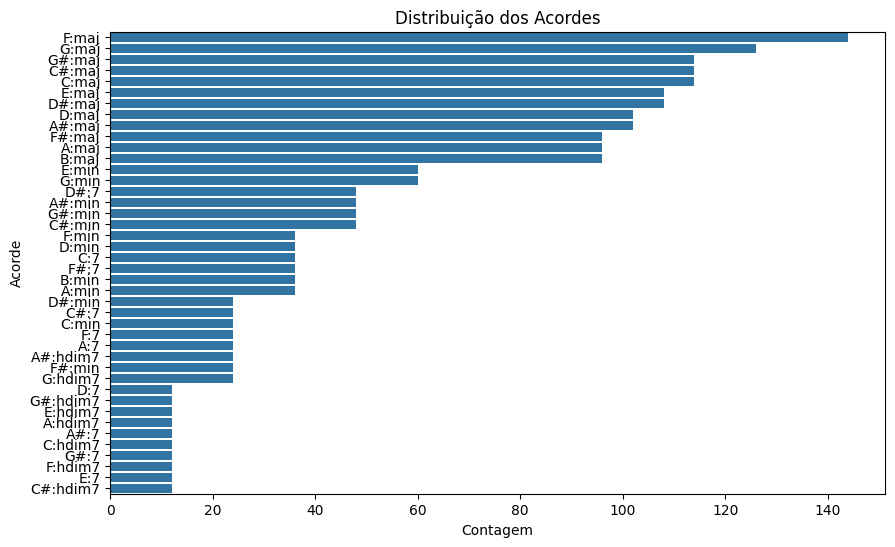

In [8]:
import seaborn as sns
df_chord = df['Acorde'].value_counts().to_frame().reset_index()
plt.figure(figsize=(10,6))
ax = sns.barplot(y = 'Acorde', x = 'count', data = df_chord )
ax.set(xlabel = 'Contagem', title = 'Distribuição dos Acordes')
plt.show()

A grande maioria dos acordes são maiores, mas também possuimos acordes sustenidos, com sétima e diminutos.


Veja que temos um certo desbalancemaneto na quantidade de exemplos de cada classe do acorde. No total, também possuimos apenas 2160 áudios para classificar um total de 42 classes, o que pode não ser suficiente para ajustar um modelo que perfome bem. 
Vamos então restringir esse trabalho a classificação dos 12 acordes maiores, que também são os mais frequentes no conjunto de dados.

In [14]:

total_arquivos = df_chord[:12].sum()['count']
print('Temos um total de', total_arquivos, 'disponíveis para os modelos de classificação.')

Temos um total de 1320 disponíveis para os modelos de classificação.


In [15]:
print('Acordes a serem classificados: ')
df_chord[:12]

Acordes a serem classificados: 


,Acorde,count
0,F:maj,144
1,G:maj,126
2,G#:maj,114
3,C#:maj,114
4,C:maj,114
5,E:maj,108
6,D#:maj,108
7,D:maj,102
8,A#:maj,102
9,F#:maj,96


Selecionamos então os 12 acordes maiores para realizar a classificação.

### Representação dos Dados

Um acorde é formado por um conjunto de notas. Podemos obter essas notas com biblioteca Mingus. \
Vejamos abaixo as notas que formam o acorde Sol Maior (G:Maj)

In [17]:
import mingus.core.chords as chords


notas = chords.from_shorthand('Gmaj')
print(notas)

['G', 'B', 'D']


Vejamos agora as notas que formam o acorde Lá sustenido menor (A#min)

In [18]:
notas = chords.from_shorthand('A#min')
print(notas)

['A#', 'C#', 'E#']


Na prática, isso significa que ao tocar um acorde no violão, estamos tocando as notas que os formam individualmente. E o mais importante, como os acordes são definidos por essas notas, não existem dois acordes diferentes com as mesmas notas em sua composição.

Assim, uma representação do aúdio que ressalte as notas individuais tocadas nos permitirá caracterizar o som dos acordes.

Inicialmente, aplicamos 'CQ Tranform' que tem por objetivo receber o áudio em forma de série temporal e representá-lo em uma frequência temporal igualmente espaçada. Depois, usamos a função 'librosa.filters.cq_to_chroma' para obter a representação dos sons na escala cromática de 12 notas.

In [7]:


CQT = np.abs(librosa.cqt(y, sr=sr))
chroma_map = librosa.filters.cq_to_chroma(CQT.shape[0], n_chroma = 12)
chromagram = chroma_map.dot(CQT)

Também efetuamos uma normalização no áudio, convertemos a escala de frequência para decibéis e aplicamos uma transformada de Fourier para obter o cromagrama.

In [8]:
# Max-normalize each time step

chromagram = librosa.util.normalize(chromagram, axis=0)

ydb = librosa.amplitude_to_db(CQT,ref=np.max)

chroma = librosa.feature.chroma_stft(y=y, sr=sr)



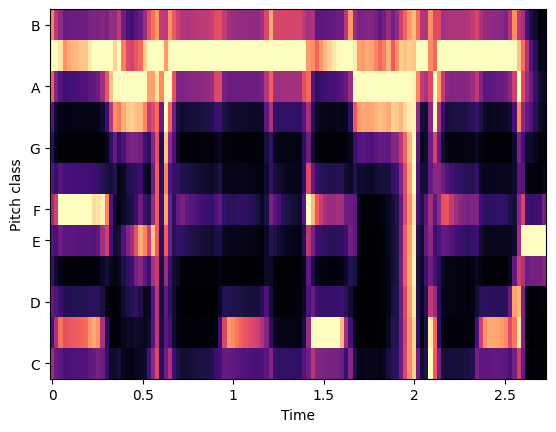

In [9]:
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')

Veja que as regiões mais claras, que representam maior frequência, são exatamente as notas formadoras do acorde, A#, C# e E# (representada como F no cromagrama)

Por fim, aplicamos a função 'librosa.decompose.nn_filter', que, substitui cada coluna do espectograma agregando seus vizinhos mais próximos no espaço, diminuindo assim o ruído presente na representação e a função 'scipy.ndimage.median_filter' que calcula a mediana de cada 9 pontos.


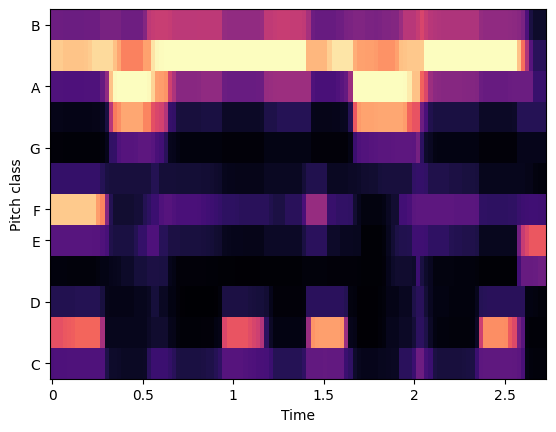

In [27]:
import scipy
chroma_min = np.minimum(chroma,
                           librosa.decompose.nn_filter(chroma,
                                                       aggregate=np.median,
                                                       metric='cosine'))

chroma_smooth = scipy.ndimage.median_filter(chroma_min, size=(1, 9))

librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='time')

Veja que que o espectograma foi suavizado. 

Os scripts completos para transformar o áudio nestes espectogramas estão documentados e disponíveis em 'PCP.ipynb'.  

## Support Vector Machine

Uma vez que todos os 1320 acordes são transformados em espectogramas, temos o seguinte conjunto de dados

Diversas abordagens foram testadas para a classificação dos 12 acordes, apresentamos aqui apenas a que obteve uma métrica de F1-Score maior no conjunto de teste.

In [9]:
X = np.load("X_PCP_FREQ2.npy")
y = np.load("y_PCP_FREQ2.npy")

In [10]:
print('Dimensões do vetor de características:')
print(X.shape)

Dimensões do vetor de características:
(1320, 12, 1216)


In [11]:
print('Acordes de cada aúdio:')
print(y[:5])

Acordes de cada aúdio:
['G#:maj' 'C#:maj' 'G#:maj' 'C#:maj' 'D:maj']


Para verificar a capacidade de generalização do modelo, dividimos o conjunto de dados em uma partição de treino (67%) e outra de teste (33%). 

Depois remodelamos a matriz X de modo a obtermos uma matriz bidimensional

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_rf = X.reshape(X.shape[0], X.shape[1]*X.shape[2] )
X_train_rf = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2] )
X_test_rf = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2] )

In [13]:
print('Dimensão de X_rf:', X_rf.shape)
print('Dimensão de X_train_rf:', X_train_rf.shape)
print('Dimensão de X_train_rf:', X_test_rf.shape)

Dimensão de X_rf: (1320, 14592)
Dimensão de X_train_rf: (884, 14592)
Dimensão de X_train_rf: (436, 14592)


In [25]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report


def metrics(model, X_test, y_test):


    preds = model.predict(X_test)
    #pred_idx = tf.math.argmax(preds_score, axis = 1)
    #y_test_idx = tf.math.argmax(y_test_encoded, axis = 1)

    #target_names = mapping.keys()

    print('F1-Score: ', f1_score(y_test, preds, average = 'macro'))
    print('Acurácia: ', accuracy_score(y_test, preds))

    print(classification_report(y_test, preds))

F1-Score:  0.7627064514272556
Acurácia:  0.7637614678899083
              precision    recall  f1-score   support

      A#:maj       0.80      0.90      0.85        31
       A:maj       0.69      0.80      0.74        25
       B:maj       0.81      0.72      0.76        29
      C#:maj       0.72      0.83      0.77        41
       C:maj       0.91      0.84      0.88        38
      D#:maj       0.89      0.67      0.76        36
       D:maj       0.76      0.81      0.78        36
       E:maj       0.56      0.75      0.64        36
      F#:maj       0.86      0.54      0.67        35
       F:maj       0.89      0.87      0.88        45
      G#:maj       0.78      0.61      0.68        46
       G:maj       0.65      0.84      0.74        38

    accuracy                           0.76       436
   macro avg       0.78      0.77      0.76       436
weighted avg       0.78      0.76      0.76       436



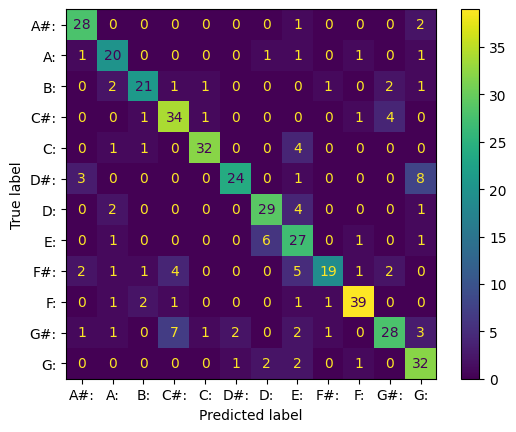

In [27]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def svm_model():

  clf = svm.SVC(decision_function_shape='ovo', probability= True)
  clf.fit(X_train_rf, y_train)
  metrics(clf, X_test_rf, y_test)
  
  preds = clf.predict(X_test_rf)
  cf_matrix = confusion_matrix(y_test, preds)

  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=[ i.strip('maj') for i  in clf.classes_ ])

  disp.plot()
  plt.show()

  return clf


model = svm_model()

Temos uma métrica de F1-Score de 0.76 indicando a capacidade do modelo em performar satisfatoriamente em todas as classes. Vemos também que a precisão e o recall mais baixo encontrados entre as classes foi de 0.56 e 0.61. 
Os acordes nos quais o modelo apresentou maior dificuldade em classificar foram E:maj, F#:maj e G#:maj.

Tomando o círculo de quintas como referência, vemos que o acorde C#:maj (Db na imagem abaixo) está próximo de G#:maj (Ab na imagem abaixo), logo os 7 erros observados na matriz de confusão para essas classes tem um peso relativamente menor, o qual não é levado em conta pelas métricas utilizadas.

Já G:maj está mais longe de D# (Eb na imagem abaixo), logo os 8 erros observados na matriz de confusão são mais grosseiros.

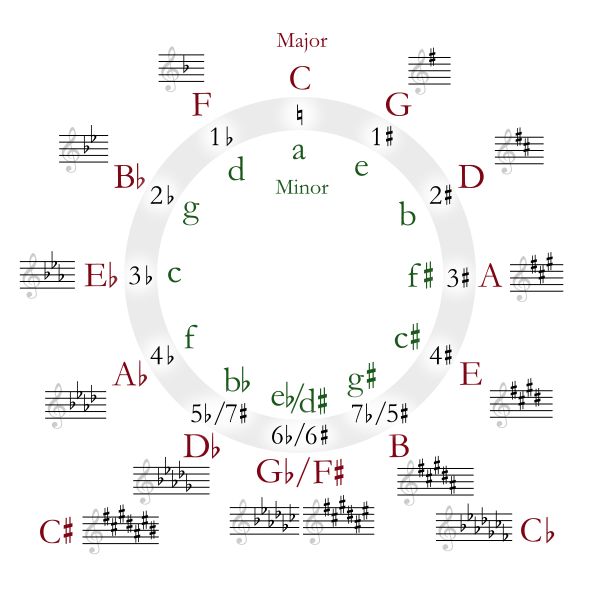

In [71]:
from IPython import display
display.Image("img/cicle_fifths.png")


O dashboard que encapsula o modelo e permite o envio do aúdio do usuário para predição está disponível no arquivo dashboard/app.py. Para rodá-lo basta rodar o seguinte comando no terminal> streamlit run dashboard/app.py.

## 5) Uso do Conhecimento

### Dashboard

O dashboard para envio de áudios foi implementado usando a biblioteca Streamlit.

Os sons gravados são salvos em um arquivo temporário chamado *'chord.wav'* na raiz da pasta do projeto. Esse arquivo é em seguida submetido para a pipeline de preprocessamento, na qual obteremos o espectograma com os filtros de suavização.

O modelo SVM foi treinado utilizando um tamanho fixo para os exemplos. Esse tamanho (um vetor de 1216 elementos) foi definido implicitamente na etada de pré-processamento quando selecionamos as gravações com maior duração e adicionamos zeros as gravações com menor duração.

In [21]:
print('Dimensão de X:', X.shape)
print('Dimensão de X_rf:', X_rf.shape)

Dimensão de X: (1320, 12, 1216)
Dimensão de X_rf: (1320, 14592)


O usuário do dashboard não necessariamente enviará áudios com a duração exata necessária para que apliquemos o modelo. Esse problema é contornado de uma maneira simples:

1. **Se o usuário manda um áudio maior do que o necessário:** cortamos o áudio no tamanho necessário (1216) 
2. **Se o usuário manda um áudio menor do que o necessário:** adicionamos zeros para preencher o vetor do áudio para o tamanho necessário

O modelos SVM previamente treinado **('dashboard/models/svc_model2.joblib')** é então carregado e fazemos a predição em termos de scores de probabilidade.
Os três acordes com maior probabilidade são então apresentados ao usuário do dashboard. 

O script completo está disponível no arquivo dashboard/app.py